# Substitution Model

**Objective**: We would like to predict when opponents are likely to make tactical substitutions and which players are likely to be involved. The goal of this component is to produce probability estimates for each player's availability (i.e. not yet being substituted) over the course of regular time gameplay. Other questions of interest include:
- What are the certain characteristics of players that are substituted for tactical reasons?
- Are there similarities in attrition rates between groups of players?
- What are the probabilities that players leave after a certain amount of time? (e.g., after half-time)

We produce a survival curve for each player on the pitch, which will help us understand when/if they might be substituted and make comparisons between different groups of players.

<div class="alert alert-block alert-info">
<b>Note:</b> This notebook is a finalized subset of the research we pursued in this analysis - it does not fully encompass our work in data analysis, feature engineering, and model testing/comparisons </div>

## Brief Introduction to Survival Analysis

The survival function relates time to the probability of surviving beyond a given time point.

Let $T$ denote a continuous non-negative random variable corresponding to a player’s survival time over the course of a game. The survival function $S(t)$ returns the probability of survival beyond time $t$ and is defined as $$ S(t) = P (T > t). $$ where $$ t <= 90 $$ 

If we observed the exact survival time of all players, i.e., everyone was substituted for tactical reasons before the game ended, the survival function at time $t$ can simply be estimated by the ratio of players surviving beyond time $t$ and the total number of players. Of course, we know this cannot be true since there are limits to the number of substitutions per game. Additionally, there are substitutions that are made for non-tactical reasons. We treat these other substitutions as censoring events.

This notebook includes covariates that are engineered from the game-state (e.g., goal differential) and the identities of the players (e.g., position) and encoding of the opponent team/manager. In other iterations of our analysis, we also explore features related to player performance/value and fatigue proxies.

<div class="alert alert-block alert-info">
<b>Reference:</b> Clark, T., Bradburn, M., Love, S. et al. Survival Analysis Part I: Basic concepts and first analyses. Br J Cancer 89, 232–238 (2003). https://doi.org/10.1038/sj.bjc.6601118  </div>

### Loading data

In [9]:
# Basic imports
import pandas as pd
import numpy as np

# Basic plotting
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.ensemble import RandomSurvivalForest

import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, KFold

from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
)
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from sklearn.inspection import permutation_importance

In [10]:
player_features = pd.read_csv('player_features.csv')
all_subs = pd.read_csv('subs_data.csv')

## Basic Models

The model works such that the log-hazard of an individual subject is a linear function of their static covariates and a population-level baseline hazard function that changes over time. These covariates can be estimated by partial likelihood.


$$h(t|x) = b_0(t)\exp{\sum_{i=1}^{n} b_i(x_i)}$$
 


-  𝑡
  represents the survival time, the hazard may vary over time.

-  ℎ(𝑡)
  is the hazard function determined by a set of  𝑛
  covariates  $(x_1, x_2,..., x_n)$

-  $b_0(t)$
  is the baseline hazard function and it is defined as the probability of experiencing the event of interest when all other covariates equal zero. It is the only time-dependent component in the model. The model makes no assumption about the baseline hazard function and assumes a parametric form for the effect of the covariates on the hazard.

-  $\exp{\sum_{i=1}^{n} b_i(x_i)}$
  is the partial hazard is a time-invariant scalar factor that only increases or decreases the baseline hazard. It is similar to the intercept in ordinary regression. The covariates or the regression coefficients x give the proportional change that can be expected in the hazard.

- The coefficients $(b_1, b_2,..., b_n)$ measure the impact (i.e., the effect size) of covariates.


The sign of the regression coefficients, $b_i$
 , plays a role in the hazard of a subject. A change in these regression coefficients or covariates will either increase or decrease the baseline hazard. A positive sign for  $b_i$
  means that the risk of an event is higher, and thus the probability for the event of interest for that particular subject is higher. Similarly, a negative sign means that the risk of the event is lower. These regression coefficients, $b$
 , are estimated by maximizing the partial likelihood.

if we want to estimate the coefficients of many features, the standard Cox model falls apart, because internally it tries to invert a matrix that becomes non-singular due to correlations among features.

This mathematical problem can be avoided by adding a $\ell_2$ penalty term on the coefficients that shrinks the coefficients to zero. The modified objective has the form
$$
\arg\max_{\beta}\quad\log \mathrm{PL}(\beta)
- \frac{\alpha}{2} \sum_{j=1}^p \beta_j^2 ,
$$

where $\mathrm{PL}(\beta)$ is the partial likelihood function of the Cox model, $\beta_1,\ldots,\beta_p$ are the coefficients for $p$ features, and $\alpha \geq 0$ is a hyper-parameter that controls the amount of shrinkage. The resulting objective is often referred to as *ridge regression*. If $\lambda$ is set to zero, we obtain the standard, unpenalized Cox model.

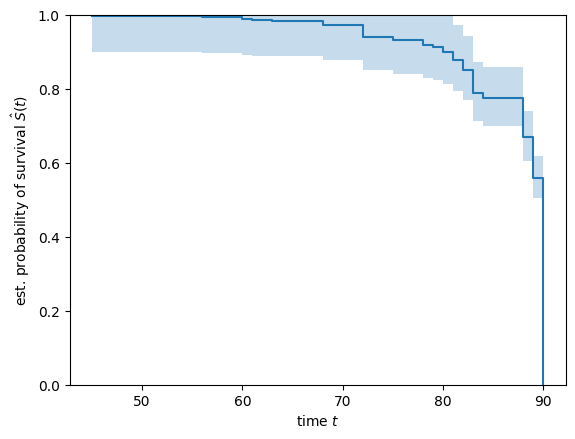

In [11]:
# non-parametric fit
time, survival_prob = kaplan_meier_estimator(
    all_subs["player_out"], all_subs["time"]
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, survival_prob*1.107, survival_prob*1/1.107, alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

## Penalized Cox Model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    player_features, all_subs[['player_out', 'time']], test_size=0.5, random_state=42)

In [13]:
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X_train,  y_train.to_records(index=False))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

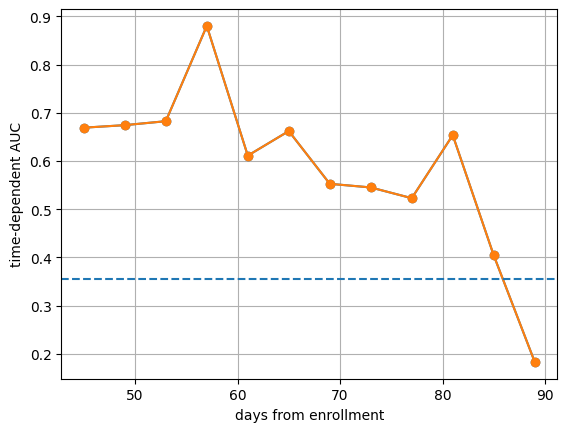

In [14]:
va_times = np.arange(45, 90, 4)
cph_risk_scores = coxnet_pipe.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
     y_train.to_records(index=False), y_test.to_records(index=False), cph_risk_scores, va_times
)
plt.plot(va_times, cph_auc, "o-", label="CoxPH (mean AUC = {:.3f})".format(cph_mean_auc))

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

It seems clear that there are shortcomings with the model performance. We could improve performance with advanced feature engineering or more complex model design.

## Random Survival Forest Model

A Random Survival Forest is an ensemble of tree-based learners. A Random Survival Forest ensures that individual trees are de-correlated by 1)
building each tree on a different bootstrap sample of the original training data, and 2)
at each node, only evaluate the split criterion for a randomly selected subset of
features and thresholds. Predictions are formed by aggregating predictions of individual
trees in the ensemble.

In [15]:
rsf = RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0)

rsf.fit(X_train, y_train.to_records(index=False))

RandomSurvivalForest(min_samples_leaf=7, random_state=0)

We can see that the performance of the random survival forest model is far superior than the performance of the penalized Cox models.

In [16]:
rsf.score(X_test, y_test.to_records(index=False)) # concordance index

0.7092360319270239

We can visualize the predicted survival functions for a set of players. 

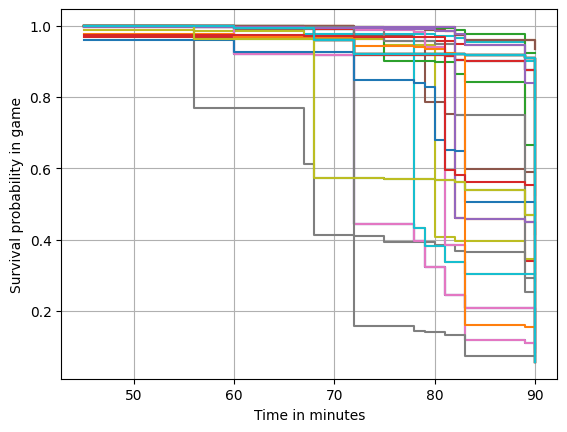

In [17]:
surv = rsf.predict_survival_function(X_test.sample(50, random_state=2), return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
    if i > 50:
        break
plt.ylabel("Survival probability in game")
plt.xlabel("Time in minutes")
plt.grid(True)

The cumulative hazard tends to increase substantially around the 70th minute of the match.

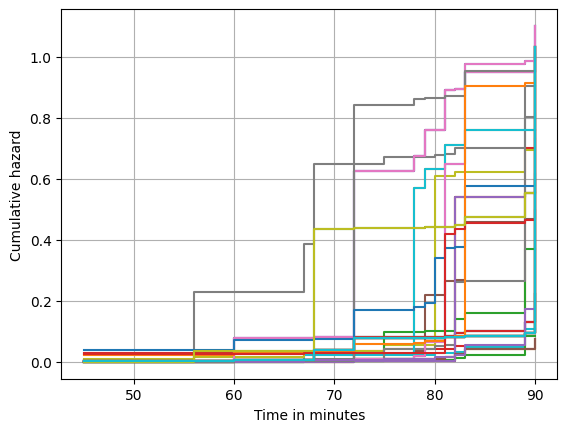

In [18]:
surv = rsf.predict_cumulative_hazard_function(X_test.sample(50, random_state=2), return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
    if i > 100:
        break
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in minutes")
plt.grid(True)

We can use permutation importance as a measure to interpret the relevance of our features. **goal_diff** seems to be important, which suggests other game-state information may also be additive.

In [19]:
result = permutation_importance(
    rsf, X_test, y_test.to_records(index=False), n_repeats=15, random_state=2
)

In [20]:
pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
goal_diff,0.112348,0.043875
player_out_position=Right Center Midfield,0.078720,0.032375
player_out_position=Center Forward,0.046902,0.024818
player_out_position=Left Wing Back,0.024971,0.004116
player_out_position=Right Center Back,0.016011,0.004483
team_name=Liverpool WFC,0.013564,0.003397
player_out_position=Left Wing,0.012999,0.003891
team_name=Manchester City WFC,0.012600,0.009089
player_out_position=Left Back,0.012296,0.010750
team_name=Leicester City WFC,0.009545,0.013853


## Model Comparisons

This section compares the CoxPH and Random Survival Forest models using a set of model comparison metrics -- time-dependent AUC and integrated brier score.

The area under the receiver operating characteristics curve (ROC curve) is a popular performance measure for binary classification task.Given a predicted risk score $\hat{f}$, the ROC curve compares the false positive rate (1 - specificity) against the true positive rate (sensitivity) for each possible value of $\hat{f}$.

Here, we consider *cumulative cases* and *dynamic controls* at a given time point $t$, which gives rise to the time-dependent cumulative/dynamic ROC at time $t$.
Cumulative cases are all individuals that experienced an event prior to or at time $t$ ($t_i 
\leq t$), whereas dynamic controls are those with $t_i>t$.
By computing the area under the cumulative/dynamic ROC at time $t$, we can determine how well a model can distinguish subjects who fail by a given time ($t_i \leq t$) from subjects who fail after this time ($t_i>t$).
Hence, it is most relevant if one wants to predict the occurrence of an event in a period up to time $t$ rather than at a specific time point $t$.


The time-dependent Brier score is an extension of the mean squared
error to right censored data. Given a time point $t$, it is defined as:

$$
\mathrm{BS}^c(t) = \frac{1}{n} \sum_{i=1}^n I(y_i \leq t \land \delta_i = 1)
        \frac{(0 - \hat{\pi}(t | \mathbf{x}_i))^2}{\hat{G}(y_i)} + I(y_i > t)
        \frac{(1 - \hat{\pi}(t | \mathbf{x}_i))^2}{\hat{G}(t)} ,
$$

where $\hat{\pi}(t | \mathbf{x})$ is a model's predicted probability of
remaining event-free up to time point $t$ for feature vector $\mathbf{x}$, and $1/\hat{G}(t)$ is an inverse probability of censoring weight. The Brier score is often used to assess calibration.
If a model predicts a 10% risk of experiencing an
event at time $t$, the observed frequency in the data
should match this percentage for a well calibrated model.
In addition, the Brier score is also a measure of
discrimination: whether a model is able to predict risk scores
that allow us to correctly determine the order of events.
The concordance index is probably the most common measure
of discrimination. However, the concordance index disregards
the actual values of predicted risk scores
– it is a ranking metric –
and is unable to tell us anything about calibration. The integrated Brier score is a single metric that integrates through $$t_0 <= t <= t_n$$


In [21]:
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
     y_train.to_records(index=False), y_test.to_records(index=False), rsf_risk_scores, va_times
)

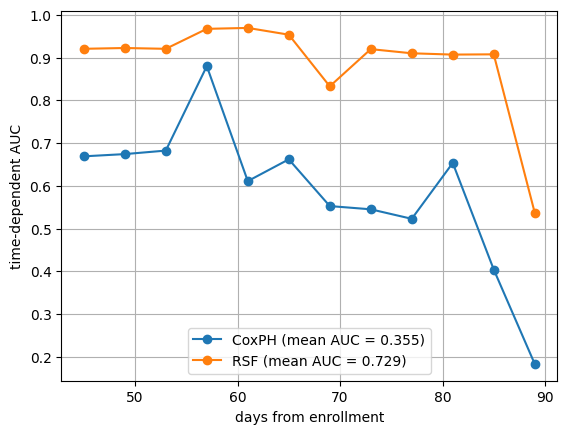

In [22]:
plt.plot(va_times, cph_auc, "o-", label="CoxPH (mean AUC = {:.3f})".format(cph_mean_auc))
plt.plot(va_times, rsf_auc, "o-", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

In [23]:
cv = KFold(n_splits=3, shuffle=True, random_state=1)

In [24]:
cv_param_grid = {
    "estimator__max_depth": np.arange(1, 10, dtype=int),
}

In [25]:
lower, upper = np.percentile(y_train["time"], [10, 90])
gbsg_times = np.arange(lower, upper + 1)

In [26]:
gcv_iauc = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(rsf, times=gbsg_times),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train.to_records(index=False))

In [27]:
rsf_surv_prob = np.row_stack([
    fn(gbsg_times)
    for fn in rsf.predict_survival_function(X_test)
])

In [28]:
cph_gbsg = CoxnetSurvivalAnalysis(l1_ratio=0.01, fit_baseline_model=True)
cph_gbsg.fit(X_train, y_train.to_records(index=False))

CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=0.01)

In [29]:
cph_surv_prob = np.row_stack([
    fn(gbsg_times)
    for fn in cph_gbsg.predict_survival_function(X_test)
])

In [30]:
random_surv_prob = 0.5 * np.ones(
    (y_test.shape[0], gbsg_times.shape[0])
)

In [31]:
score_brier = pd.Series(
    [
        integrated_brier_score(y_train.to_records(index=False), y_test.to_records(index=False), prob, gbsg_times)
        for prob in (rsf_surv_prob, cph_surv_prob, random_surv_prob)
    ],
    index=["RSF", "CPH", "Random"],
    name="IBS"
)

score_brier

RSF       0.014619
CPH       0.019892
Random    0.239674
Name: IBS, dtype: float64

Clearly, the random survival forest model outperforms both the CoxPH model and the random baseline. This model allows us to make better predictions on who will be substituted and when they will be substituted. We can improve our model further by adding various in-game features - including information about the current game-state and individual performances.